In [1]:
import importlib
import optuna

In [2]:
from analysis_functions import *

In [3]:
importlib.reload(sys.modules['analysis_functions'])
from analysis_functions import *

In [13]:
X_stress_components_new = opener('X_stress_components_new', path_import='./resourses/')
X_strain_components_new = opener('X_strain_components_new', path_import='./resourses/')
y_stress_components_new = opener('y_stress_components_new', path_import='./resourses/')
y_strain_components_new = opener('y_strain_components_new', path_import='./resourses/')
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')

./resourses//X_stress_components_new.pkl
./resourses//X_strain_components_new.pkl
./resourses//y_stress_components_new.pkl
./resourses//y_strain_components_new.pkl


In [14]:
X_stress_components_new.shape

(3, 2678, 5)

In [15]:
df_results = pd.DataFrame(
    columns=[
            # Constructional
             'n_layers', 'n_neurons', 'solver', 'max_iter',
             'learning_rate_init', 'learning_rate', 'early_stopping',
             'activation', 'n_splits', 'alpha',

            # Resultant _val
             'explained_variance_score_val', 'median_absolute_error_val',
             'mean_squared_error_val', 'mean_absolute_error_val',
             'r2_score_val', 'max_error_val', 'AIC_val', 'BIC_val',

            # Resultant _test
             'explained_variance_score_test', 'median_absolute_error_test',
             'mean_squared_error_test', 'mean_absolute_error_test',
             'r2_score_test', 'max_error_test', 'AIC_test', 'BIC_test'
            ]
    )

In [16]:
component_num = 1
n_trials = 200

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [18]:
import shutil

def plot_results(x, y, model_name, do_zip=False, dpi=500, delete_and_rewrite=True):
    cur_X_test, cur_y_test, *_ = get_train_test(x, y)

    model = opener(model_name)
    cur_prediction = model.predict(cur_X_test)
    print('rmse = ', np.sqrt(mean_squared_error(cur_y_test, cur_prediction)))
    
    if delete_and_rewrite:
        os.makedirs(model_name, exist_ok=True)
    
    for i, item in enumerate(cur_X_test[::20]):
        fig = plt.figure(figsize=(5, 4))
        plt.plot(
            cur_X_test[i*20:(i+1)*20, -1],
            cur_prediction[i*20:(i+1)*20],
            '-o',
            label='predicted'
        )
        plt.plot(
            cur_X_test[i*20:(i+1)*20, -1],
            cur_y_test[i*20:(i+1)*20],
            '-o',
            label='real'
        )
        title = f'red {item[0]}, cal {item[1]}, alpha {int(item[2])}, fric {item[3]}'
        plt.title(title)
        plt.legend(loc='best')
        plt.xlabel('r, -')
        plt.ylabel('$\sigma$, MPa')
        # plt.show()
        plt.savefig(''.join((model_name, '/', title, '.png')), format='png', dpi=dpi)
        plt.close()
        # break
    if do_zip: shutil.make_archive(model_name, 'zip', model_name)

In [19]:
X_stress_components_new[0].max(axis=0)

array([ 0.25,  1.  , 20.  ,  0.1 , 40.  ])

# KAN 

In [ ]:
%pip install pykan

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "/Users/i.grebenkin/pythonProjects/учеба/wire_drawing/.venv/lib/python3.9/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 251, in build_wheel
          return _build_backend().build_wheel

In [29]:
%pip install torch

from kan import *

  Using cached torch-2.6.0-cp39-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached fsspec-2025.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 1.0 MB/s eta 0:00:0000:0100:030m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 709.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 996.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 498.3 kB/s eta 0:00:0000:01m

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X_stress_components_new[0], y_stress_components_new[0])
)

In [31]:
train_list_X[0].shape, train_list_y[0].shape

((37480, 6), (37480,))

In [32]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
my_x = [train_list_X[0], val_list_X[0]] # a list of numpy arrays
my_x = train_list_X[0].T # a list of numpy arrays
# my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)
my_y = [train_list_y[0], val_list_y[0]] # another list of numpy arrays (targets)
my_y = train_list_y[0] # another list of numpy arrays (targets)

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

test_tensor_x = torch.Tensor(cur_X_test.T)
test_tensor_y = torch.Tensor(cur_y_test)

# my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
# my_dataloader = DataLoader(my_dataset) # create your dataloader

my_dataset = {
    'train_input': tensor_x,
    'test_input': test_tensor_x,
    'train_label': tensor_y,
    'test_label': test_tensor_y
}

In [ ]:
def prepare_my_dataset(X_stress_components_new, y_stress_components_new):
    """Generate dataset for training and testing KAN model"""
    cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
        split_transform_one_comp_cv(X_stress_components_new, y_stress_components_new)
    )

    tensor_x = torch.Tensor(train_list_X[0].T)
    tensor_y = torch.Tensor(train_list_y[0])

    test_tensor_x = torch.Tensor(cur_X_test.T)
    test_tensor_y = torch.Tensor(cur_y_test)

    my_dataset = {
        "train_input": tensor_x,
        "test_input": test_tensor_x,
        "train_label": tensor_y,
        "test_label": test_tensor_y,
    }
    return my_dataset

In [33]:
from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[6,5,5,1], seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [84]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 10)
    n_steps = trial.suggest_int("n_steps", 1, 1000)
    seed = RANDOM_STATE

    inner_layers_config = []
    for n_neurons in range(1, n_layers + 1):
        inner_layers_config.append(trial.suggest_int(f"n_neurons_{n_neurons}", 1, 10))
    
    try:
        # Create a new KAN model with suggested hyperparameters
        model = KAN(width=[6] + inner_layers_config + [1], seed=seed)
        print(f"Current configuration: {inner_layers_config}")
        # Train the model
        model.fit(my_dataset, opt="LBFGS", steps=n_steps)

        # Predict the output
        prediction = model(my_dataset["test_input"].T).detach().numpy().ravel()

        ground_truth = my_dataset["test_label"].detach().numpy()

        rmse = np.sqrt(mean_squared_error(ground_truth, prediction))
    except Exception as e:
        print(f"Error: {e}")
        rmse = np.inf

    return rmse

# Use Optuna to tune the hyperparameters of the KAN
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Get the best hyperparameters
best_params = study.best_params
print('Best hyperparameters:', best_params)



[I 2025-02-02 19:13:14,027] A new study created in memory with name: no-name-c1a57234-e1b1-47b2-aa79-ead37beb2257


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 8, 7, 2, 6, 2, 1]


| train_loss: 8.47e+00 | test_loss: 5.64e+01 | reg: 7.45e+01 | : 100%|█| 57/57 [00:04<00:00, 12.09it
[I 2025-02-02 19:13:18,903] Trial 0 finished with value: 57.377538155323684 and parameters: {'n_layers': 9, 'n_steps': 57, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 2, 'n_neurons_7': 6, 'n_neurons_8': 2, 'n_neurons_9': 1}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1]


| train_loss: 8.47e+00 | test_loss: 5.86e+01 | reg: 5.47e+00 | : 100%|█| 963/963 [00:11<00:00, 82.68
[I 2025-02-02 19:13:30,589] Trial 1 finished with value: 60.178875615223156 and parameters: {'n_layers': 1, 'n_steps': 963, 'n_neurons_1': 1}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 6, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 677/677 [00:59<00:00, 11.31it/s]
[I 2025-02-02 19:14:30,535] Trial 2 finished with value: inf and parameters: {'n_layers': 4, 'n_steps': 677, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 6, 'n_neurons_4': 2}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 1]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 943/943 [00:52<00:00, 18.10it/s]
[I 2025-02-02 19:15:22,663] Trial 3 finished with value: inf and parameters: {'n_layers': 2, 'n_steps': 943, 'n_neurons_1': 4, 'n_neurons_2': 1}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 1, 8, 10, 10]


| train_loss: 5.88e+01 | test_loss: 7.24e+03 | reg: 3.52e+02 | : 100%|█| 302/302 [00:09<00:00, 30.26
[I 2025-02-02 19:15:32,761] Trial 4 finished with value: 1761.326701665537 and parameters: {'n_layers': 5, 'n_steps': 302, 'n_neurons_1': 6, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 10}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 3]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 32/32 [00:01<00:00, 17.57it/s]
[I 2025-02-02 19:15:34,630] Trial 5 finished with value: inf and parameters: {'n_layers': 2, 'n_steps': 32, 'n_neurons_1': 5, 'n_neurons_2': 3}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8]


| train_loss: 8.47e+00 | test_loss: 5.86e+01 | reg: 4.93e+01 | : 100%|█| 12/12 [00:00<00:00, 43.07it
[I 2025-02-02 19:15:34,966] Trial 6 finished with value: 60.4056518335619 and parameters: {'n_layers': 1, 'n_steps': 12, 'n_neurons_1': 8}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 10, 1]


| train_loss: 8.47e+00 | test_loss: 5.84e+01 | reg: 4.21e+01 | : 100%|█| 310/310 [00:08<00:00, 37.85
[I 2025-02-02 19:15:43,197] Trial 7 finished with value: 62.94675484337934 and parameters: {'n_layers': 3, 'n_steps': 310, 'n_neurons_1': 1, 'n_neurons_2': 10, 'n_neurons_3': 1}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 7, 2, 10, 6, 5, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 38/38 [00:05<00:00,  6.40it/s]
[I 2025-02-02 19:15:49,251] Trial 8 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 38, 'n_neurons_1': 8, 'n_neurons_2': 7, 'n_neurons_3': 2, 'n_neurons_4': 10, 'n_neurons_5': 6, 'n_neurons_6': 5, 'n_neurons_7': 10}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 9, 1, 10, 7, 2, 9, 10, 8]


| train_loss: 8.49e+00 | test_loss: 6.05e+01 | reg: 3.73e+03 | : 100%|█| 899/899 [00:44<00:00, 20.01
[I 2025-02-02 19:16:34,315] Trial 9 finished with value: 59.771723545058286 and parameters: {'n_layers': 9, 'n_steps': 899, 'n_neurons_1': 1, 'n_neurons_2': 9, 'n_neurons_3': 1, 'n_neurons_4': 10, 'n_neurons_5': 7, 'n_neurons_6': 2, 'n_neurons_7': 9, 'n_neurons_8': 10, 'n_neurons_9': 8}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 6, 10, 5, 1, 1, 2, 1, 1, 9]


| train_loss: 8.47e+00 | test_loss: 5.64e+01 | reg: 5.40e+01 | : 100%|█| 307/307 [00:16<00:00, 18.25
[I 2025-02-02 19:16:51,317] Trial 10 finished with value: 58.73538922375185 and parameters: {'n_layers': 10, 'n_steps': 307, 'n_neurons_1': 3, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 5, 'n_neurons_5': 1, 'n_neurons_6': 1, 'n_neurons_7': 2, 'n_neurons_8': 1, 'n_neurons_9': 1, 'n_neurons_10': 9}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 6, 10, 5, 1, 1, 1, 1, 1, 9]


| train_loss: 8.47e+00 | test_loss: 6.04e+01 | reg: 7.20e+01 | : 100%|█| 324/324 [00:16<00:00, 19.26
[I 2025-02-02 19:17:08,339] Trial 11 finished with value: 57.48113226447658 and parameters: {'n_layers': 10, 'n_steps': 324, 'n_neurons_1': 3, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 5, 'n_neurons_5': 1, 'n_neurons_6': 1, 'n_neurons_7': 1, 'n_neurons_8': 1, 'n_neurons_9': 1, 'n_neurons_10': 9}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 4, 10, 6, 1, 1, 4, 1]


| train_loss: 1.42e+01 | test_loss: 4.66e+01 | reg: 9.25e+01 | : 100%|█| 527/527 [00:26<00:00, 20.18
[I 2025-02-02 19:17:34,571] Trial 12 finished with value: 69.21594238098258 and parameters: {'n_layers': 8, 'n_steps': 527, 'n_neurons_1': 3, 'n_neurons_2': 4, 'n_neurons_3': 10, 'n_neurons_4': 6, 'n_neurons_5': 1, 'n_neurons_6': 1, 'n_neurons_7': 4, 'n_neurons_8': 1}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 7, 7, 6, 4, 5, 7, 4, 1, 5]


| train_loss: 8.53e+00 | test_loss: 2.80e+02 | reg: 1.52e+02 | : 100%|█| 195/195 [00:15<00:00, 12.36
[I 2025-02-02 19:17:50,536] Trial 13 finished with value: 1622.2126864255501 and parameters: {'n_layers': 10, 'n_steps': 195, 'n_neurons_1': 3, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 4, 'n_neurons_6': 5, 'n_neurons_7': 7, 'n_neurons_8': 4, 'n_neurons_9': 1, 'n_neurons_10': 5}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 3, 4, 7, 9, 8, 1]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 502/502 [01:29<00:00,  5.62it/s]
[I 2025-02-02 19:19:20,031] Trial 14 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 502, 'n_neurons_1': 6, 'n_neurons_2': 3, 'n_neurons_3': 4, 'n_neurons_4': 7, 'n_neurons_5': 9, 'n_neurons_6': 8, 'n_neurons_7': 1}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 8, 4, 4, 3, 5, 4]


| train_loss: 8.47e+00 | test_loss: 6.97e+01 | reg: 4.33e+02 | : 100%|█| 178/178 [00:10<00:00, 17.37
[I 2025-02-02 19:19:30,424] Trial 15 finished with value: 70.02848890139283 and parameters: {'n_layers': 8, 'n_steps': 178, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 4, 'n_neurons_6': 3, 'n_neurons_7': 5, 'n_neurons_8': 4}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 7, 4, 8, 8, 3, 7, 1, 3, 10]


| train_loss: 8.47e+00 | test_loss: 6.73e+01 | reg: 3.33e+02 | : 100%|█| 158/158 [00:22<00:00,  6.90
[I 2025-02-02 19:19:53,532] Trial 16 finished with value: 78.1235906122872 and parameters: {'n_layers': 10, 'n_steps': 158, 'n_neurons_1': 4, 'n_neurons_2': 7, 'n_neurons_3': 4, 'n_neurons_4': 8, 'n_neurons_5': 8, 'n_neurons_6': 3, 'n_neurons_7': 7, 'n_neurons_8': 1, 'n_neurons_9': 3, 'n_neurons_10': 10}. Best is trial 0 with value: 57.377538155323684.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 9, 3, 4, 10]


| train_loss: 8.51e+00 | test_loss: 1.22e+02 | reg: 2.49e+02 | : 100%|█| 644/644 [00:23<00:00, 26.88
[I 2025-02-02 19:20:17,593] Trial 17 finished with value: 54.71927425148633 and parameters: {'n_layers': 6, 'n_steps': 644, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 9, 'n_neurons_4': 3, 'n_neurons_5': 4, 'n_neurons_6': 10}. Best is trial 17 with value: 54.71927425148633.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 8, 1, 4, 10]


| train_loss: 8.48e+00 | test_loss: 5.28e+01 | reg: 2.64e+02 | : 100%|█| 726/726 [00:33<00:00, 21.54
[I 2025-02-02 19:20:51,404] Trial 18 finished with value: 50.233091935402754 and parameters: {'n_layers': 6, 'n_steps': 726, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 1, 'n_neurons_5': 4, 'n_neurons_6': 10}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 2, 9, 1, 4, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 763/763 [01:53<00:00,  6.74it/s]
[I 2025-02-02 19:22:44,668] Trial 19 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 763, 'n_neurons_1': 7, 'n_neurons_2': 2, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 4, 'n_neurons_6': 10}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 8, 3, 3]


| train_loss: 8.47e+00 | test_loss: 5.06e+01 | reg: 1.14e+02 | : 100%|█| 660/660 [00:22<00:00, 29.15
[I 2025-02-02 19:23:07,405] Trial 20 finished with value: 86.81912265505653 and parameters: {'n_layers': 5, 'n_steps': 660, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 3}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 6, 1, 6, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 809/809 [02:02<00:00,  6.58it/s]
[I 2025-02-02 19:25:10,372] Trial 21 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 809, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 1, 'n_neurons_5': 6, 'n_neurons_6': 10}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [10, 3, 7, 3, 5, 8, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 626/626 [01:52<00:00,  5.58it/s]
[I 2025-02-02 19:27:02,741] Trial 22 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 626, 'n_neurons_1': 10, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 3, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 7}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 9, 2, 3, 8, 4, 8]


| train_loss: 8.52e+00 | test_loss: 2.54e+02 | reg: 2.04e+03 | : 100%|█| 581/581 [00:31<00:00, 18.65
[I 2025-02-02 19:27:34,065] Trial 23 finished with value: 2122.3069994701523 and parameters: {'n_layers': 8, 'n_steps': 581, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 9, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 4, 'n_neurons_8': 8}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 4, 7, 3, 7]


| train_loss: 4.10e+01 | test_loss: 3.24e+03 | reg: 2.37e+02 | : 100%|█| 784/784 [00:26<00:00, 29.47
[I 2025-02-02 19:28:00,775] Trial 24 finished with value: 6604.613539034664 and parameters: {'n_layers': 5, 'n_steps': 784, 'n_neurons_1': 4, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 3, 'n_neurons_5': 7}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 5, 8, 5, 9]


| train_loss: 1.28e+01 | test_loss: 7.45e+04 | reg: 1.50e+02 | : 100%|█| 398/398 [00:17<00:00, 22.53
[I 2025-02-02 19:28:18,554] Trial 25 finished with value: 150300.75363749845 and parameters: {'n_layers': 6, 'n_steps': 398, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 5, 'n_neurons_4': 8, 'n_neurons_5': 5, 'n_neurons_6': 9}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 3, 9, 1]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 731/731 [01:21<00:00,  8.95it/s]
[I 2025-02-02 19:29:40,367] Trial 26 finished with value: inf and parameters: {'n_layers': 4, 'n_steps': 731, 'n_neurons_1': 5, 'n_neurons_2': 3, 'n_neurons_3': 9, 'n_neurons_4': 1}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 5, 8, 8, 3, 6, 8, 5, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 421/421 [01:30<00:00,  4.68it/s]
[I 2025-02-02 19:31:10,609] Trial 27 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 421, 'n_neurons_1': 4, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 3, 'n_neurons_6': 6, 'n_neurons_7': 8, 'n_neurons_8': 5, 'n_neurons_9': 6}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 1, 5, 2]


| train_loss: 1.20e+01 | test_loss: 6.85e+04 | reg: 9.04e+01 | : 100%|█| 867/867 [00:23<00:00, 37.67
[I 2025-02-02 19:31:33,717] Trial 28 finished with value: 60441.253196802594 and parameters: {'n_layers': 4, 'n_steps': 867, 'n_neurons_1': 7, 'n_neurons_2': 1, 'n_neurons_3': 5, 'n_neurons_4': 2}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 7, 4, 7, 7, 3, 7, 10]


| train_loss: 5.49e+01 | test_loss: 3.58e+01 | reg: 1.67e+01 | : 100%|█| 570/570 [00:36<00:00, 15.45
[I 2025-02-02 19:32:10,814] Trial 29 finished with value: 55.674539036035135 and parameters: {'n_layers': 9, 'n_steps': 570, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 4, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 3, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 9, 4, 2, 7, 4]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.25e+01 | : 100%|█| 555/555 [00:26<00:00, 21.01
[I 2025-02-02 19:32:37,353] Trial 30 finished with value: 57.408848437381586 and parameters: {'n_layers': 7, 'n_steps': 555, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 9, 'n_neurons_4': 4, 'n_neurons_5': 2, 'n_neurons_6': 7, 'n_neurons_7': 4}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 7, 4, 7, 10, 3, 7, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 431/431 [01:37<00:00,  4.44it/s]
[I 2025-02-02 19:34:14,575] Trial 31 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 431, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 4, 'n_neurons_5': 7, 'n_neurons_6': 10, 'n_neurons_7': 3, 'n_neurons_8': 7, 'n_neurons_9': 10}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 6, 3, 8, 9, 6, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 709/709 [02:27<00:00,  4.82it/s]
[I 2025-02-02 19:36:41,793] Trial 32 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 709, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 6, 'n_neurons_4': 3, 'n_neurons_5': 8, 'n_neurons_6': 9, 'n_neurons_7': 6, 'n_neurons_8': 7}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 8, 5, 6, 4, 5, 3, 5]


| train_loss: 1.08e+02 | test_loss: 4.22e+01 | reg: 5.17e+01 | : 100%|█| 588/588 [00:32<00:00, 17.94
[I 2025-02-02 19:37:14,726] Trial 33 finished with value: 57.40641373479644 and parameters: {'n_layers': 9, 'n_steps': 588, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 5, 'n_neurons_5': 6, 'n_neurons_6': 4, 'n_neurons_7': 5, 'n_neurons_8': 3, 'n_neurons_9': 5}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 1, 7, 9, 5, 7]


| train_loss: 8.47e+00 | test_loss: 5.60e+01 | reg: 1.03e+02 | : 100%|█| 652/652 [00:28<00:00, 22.63
[I 2025-02-02 19:37:43,672] Trial 34 finished with value: 59.37656659117509 and parameters: {'n_layers': 6, 'n_steps': 652, 'n_neurons_1': 3, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 5, 'n_neurons_6': 7}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 6, 2, 8, 9, 3, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 460/460 [01:33<00:00,  4.94it/s]
[I 2025-02-02 19:39:16,938] Trial 35 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 460, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 8, 'n_neurons_6': 9, 'n_neurons_7': 3, 'n_neurons_8': 9}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 1, 8, 4, 7, 6, 6]


| train_loss: 1.06e+02 | test_loss: 4.89e+01 | reg: 8.68e+01 | : 100%|█| 827/827 [00:52<00:00, 15.83
[I 2025-02-02 19:40:09,361] Trial 36 finished with value: 68.9687924784645 and parameters: {'n_layers': 7, 'n_steps': 827, 'n_neurons_1': 4, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 7, 'n_neurons_6': 6, 'n_neurons_7': 6}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 702/702 [01:05<00:00, 10.72it/s]
[I 2025-02-02 19:41:14,893] Trial 37 finished with value: inf and parameters: {'n_layers': 3, 'n_steps': 702, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 9}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 1, 5, 6, 4]


| train_loss: 8.47e+00 | test_loss: 2.12e+03 | reg: 1.46e+02 | : 100%|█| 965/965 [00:43<00:00, 22.28
[I 2025-02-02 19:41:58,308] Trial 38 finished with value: 3297.758936004874 and parameters: {'n_layers': 5, 'n_steps': 965, 'n_neurons_1': 7, 'n_neurons_2': 1, 'n_neurons_3': 5, 'n_neurons_4': 6, 'n_neurons_5': 4}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 2, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 610/610 [00:56<00:00, 10.82it/s]
[I 2025-02-02 19:42:54,802] Trial 39 finished with value: inf and parameters: {'n_layers': 3, 'n_steps': 610, 'n_neurons_1': 9, 'n_neurons_2': 2, 'n_neurons_3': 7}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 8, 7, 10, 7, 3, 6, 10]


| train_loss: 1.17e+01 | test_loss: 1.97e+03 | reg: 1.66e+02 | : 100%|█| 86/86 [00:09<00:00,  9.26it


saving model version 0.1


[I 2025-02-02 19:43:04,404] Trial 40 finished with value: 2192.9253293261036 and parameters: {'n_layers': 9, 'n_steps': 86, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 10, 'n_neurons_6': 7, 'n_neurons_7': 3, 'n_neurons_8': 6, 'n_neurons_9': 10}. Best is trial 18 with value: 50.233091935402754.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 8, 5, 6, 4, 5, 3, 5]


| train_loss: 1.08e+02 | test_loss: 4.22e+01 | reg: 5.17e+01 | : 100%|█| 539/539 [00:31<00:00, 17.27
[I 2025-02-02 19:43:35,767] Trial 41 finished with value: 57.40641373479644 and parameters: {'n_layers': 9, 'n_steps': 539, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 5, 'n_neurons_5': 6, 'n_neurons_6': 4, 'n_neurons_7': 5, 'n_neurons_8': 3, 'n_neurons_9': 5}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 9, 5, 6, 4, 5, 3, 4]


| train_loss: 8.60e+00 | test_loss: 1.41e+04 | reg: 6.75e+02 | : 100%|█| 583/583 [00:23<00:00, 24.89
[I 2025-02-02 19:43:59,355] Trial 42 finished with value: 388.172682256235 and parameters: {'n_layers': 9, 'n_steps': 583, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 9, 'n_neurons_4': 5, 'n_neurons_5': 6, 'n_neurons_6': 4, 'n_neurons_7': 5, 'n_neurons_8': 3, 'n_neurons_9': 4}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 10, 4, 5, 3, 2, 3, 7, 1]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 381/381 [01:31<00:00,  4.14it/s]
[I 2025-02-02 19:45:31,518] Trial 43 finished with value: inf and parameters: {'n_layers': 10, 'n_steps': 381, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 10, 'n_neurons_4': 4, 'n_neurons_5': 5, 'n_neurons_6': 3, 'n_neurons_7': 2, 'n_neurons_8': 3, 'n_neurons_9': 7, 'n_neurons_10': 1}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3]


| train_loss: 8.47e+00 | test_loss: 5.51e+01 | reg: 2.82e+01 | : 100%|█| 491/491 [00:09<00:00, 53.19
[I 2025-02-02 19:45:40,788] Trial 44 finished with value: 83.87364939300066 and parameters: {'n_layers': 1, 'n_steps': 491, 'n_neurons_1': 3}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 8, 3, 6, 2, 6, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 746/746 [02:29<00:00,  4.98it/s]
[I 2025-02-02 19:48:10,730] Trial 45 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 746, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 6, 'n_neurons_6': 2, 'n_neurons_7': 6, 'n_neurons_8': 2}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 9, 7, 7, 7, 4, 4, 5, 3]


| train_loss: 3.25e+01 | test_loss: 2.68e+01 | reg: 5.89e+02 | : 100%|█| 676/676 [00:44<00:00, 15.12
[I 2025-02-02 19:48:55,656] Trial 46 finished with value: 59.63098805426693 and parameters: {'n_layers': 9, 'n_steps': 676, 'n_neurons_1': 6, 'n_neurons_2': 9, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 7, 'n_neurons_6': 4, 'n_neurons_7': 4, 'n_neurons_8': 5, 'n_neurons_9': 3}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 6, 5, 8, 5, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 245/245 [00:45<00:00,  5.40it/s]
[I 2025-02-02 19:49:41,176] Trial 47 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 245, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 6, 'n_neurons_4': 5, 'n_neurons_5': 8, 'n_neurons_6': 5, 'n_neurons_7': 2}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 2, 10, 6, 6, 2, 8, 6, 8, 1]


| train_loss: 1.07e+02 | test_loss: 4.14e+01 | reg: 8.46e+01 | : 100%|█| 623/623 [00:53<00:00, 11.61
[I 2025-02-02 19:50:35,047] Trial 48 finished with value: 57.48080734376149 and parameters: {'n_layers': 10, 'n_steps': 623, 'n_neurons_1': 3, 'n_neurons_2': 2, 'n_neurons_3': 10, 'n_neurons_4': 6, 'n_neurons_5': 6, 'n_neurons_6': 2, 'n_neurons_7': 8, 'n_neurons_8': 6, 'n_neurons_9': 8, 'n_neurons_10': 1}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 9, 2, 9]


| train_loss: 1.01e+02 | test_loss: 3.83e+01 | reg: 1.73e+02 | : 100%|█| 508/508 [00:31<00:00, 16.00
[I 2025-02-02 19:51:06,929] Trial 49 finished with value: 57.29397959346383 and parameters: {'n_layers': 6, 'n_steps': 508, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 5, 2, 9, 2, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 485/485 [01:19<00:00,  6.10it/s]
[I 2025-02-02 19:52:26,620] Trial 50 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 485, 'n_neurons_1': 5, 'n_neurons_2': 5, 'n_neurons_3': 2, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 9, 10, 2]


| train_loss: 1.09e+02 | test_loss: 4.24e+01 | reg: 2.16e+01 | : 100%|█| 573/573 [00:22<00:00, 25.75
[I 2025-02-02 19:52:49,001] Trial 51 finished with value: 57.23240851112571 and parameters: {'n_layers': 5, 'n_steps': 573, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 9, 'n_neurons_4': 10, 'n_neurons_5': 2}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 9, 10, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 353/353 [00:45<00:00,  7.70it/s]
[I 2025-02-02 19:53:34,957] Trial 52 finished with value: inf and parameters: {'n_layers': 5, 'n_steps': 353, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 9, 'n_neurons_4': 10, 'n_neurons_5': 2}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 10, 9]


| train_loss: 6.80e+01 | test_loss: 2.80e+02 | reg: 1.49e+03 | : 100%|█| 534/534 [00:18<00:00, 29.28
[I 2025-02-02 19:53:53,313] Trial 53 finished with value: 607.1915626472423 and parameters: {'n_layers': 4, 'n_steps': 534, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 10, 'n_neurons_4': 9}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 9, 10, 1, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 679/679 [01:51<00:00,  6.08it/s]
[I 2025-02-02 19:55:45,098] Trial 54 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 679, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 9, 'n_neurons_4': 10, 'n_neurons_5': 1, 'n_neurons_6': 10}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 6, 8, 9, 3]


| train_loss: 9.29e+00 | test_loss: 9.57e+01 | reg: 1.46e+02 | : 100%|█| 451/451 [00:20<00:00, 21.98
[I 2025-02-02 19:56:05,757] Trial 55 finished with value: 144.38309636389226 and parameters: {'n_layers': 5, 'n_steps': 451, 'n_neurons_1': 3, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 9, 'n_neurons_5': 3}. Best is trial 18 with value: 50.233091935402754.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 8]


| train_loss: 8.47e+00 | test_loss: 5.94e+01 | reg: 4.20e+01 | : 100%|█| 263/263 [00:06<00:00, 38.86
[I 2025-02-02 19:56:12,584] Trial 56 finished with value: 45.98237869435013 and parameters: {'n_layers': 2, 'n_steps': 263, 'n_neurons_1': 2, 'n_neurons_2': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 8]


| train_loss: 8.47e+00 | test_loss: 4.73e+02 | reg: 4.06e+02 | : 100%|█| 278/278 [00:06<00:00, 40.93
[I 2025-02-02 19:56:19,450] Trial 57 finished with value: 753.0347352546229 and parameters: {'n_layers': 2, 'n_steps': 278, 'n_neurons_1': 1, 'n_neurons_2': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2]


| train_loss: 8.47e+00 | test_loss: 1.38e+02 | reg: 1.75e+01 | : 100%|█| 83/83 [00:01<00:00, 53.81it
[I 2025-02-02 19:56:21,040] Trial 58 finished with value: 72.42194073621611 and parameters: {'n_layers': 1, 'n_steps': 83, 'n_neurons_1': 2}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 8]


| train_loss: 8.48e+00 | test_loss: 1.15e+04 | reg: 1.06e+02 | : 100%|█| 505/505 [00:12<00:00, 42.07
[I 2025-02-02 19:56:33,112] Trial 59 finished with value: 13673.17958632885 and parameters: {'n_layers': 2, 'n_steps': 505, 'n_neurons_1': 3, 'n_neurons_2': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 8, 10]


| train_loss: 8.48e+00 | test_loss: 1.73e+02 | reg: 3.67e+02 | : 100%|█| 913/913 [00:25<00:00, 35.78
[I 2025-02-02 19:56:58,730] Trial 60 finished with value: 254.48676138210018 and parameters: {'n_layers': 3, 'n_steps': 913, 'n_neurons_1': 1, 'n_neurons_2': 8, 'n_neurons_3': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 9, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 234/234 [00:27<00:00,  8.50it/s]
[I 2025-02-02 19:57:26,410] Trial 61 finished with value: inf and parameters: {'n_layers': 4, 'n_steps': 234, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 9, 'n_neurons_4': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 7, 10, 2, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████████| 9/9 [00:01<00:00,  5.66it/s]
[I 2025-02-02 19:57:28,148] Trial 62 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 9, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 9, 8, 8, 1, 8, 10]


| train_loss: 8.30e+01 | test_loss: 3.05e+01 | reg: 5.69e+02 | : 100%|█| 143/143 [00:12<00:00, 11.48
[I 2025-02-02 19:57:40,775] Trial 63 finished with value: 58.09572725588884 and parameters: {'n_layers': 7, 'n_steps': 143, 'n_neurons_1': 4, 'n_neurons_2': 9, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 1, 'n_neurons_6': 8, 'n_neurons_7': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 3, 9, 9, 4]


| train_loss: 8.69e+00 | test_loss: 2.30e+03 | reg: 1.78e+02 | : 100%|█| 562/562 [00:23<00:00, 24.21
[I 2025-02-02 19:58:04,134] Trial 64 finished with value: 3609.723673634867 and parameters: {'n_layers': 5, 'n_steps': 562, 'n_neurons_1': 8, 'n_neurons_2': 3, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 4}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 10, 10, 1, 3, 10, 10]


| train_loss: 1.08e+02 | test_loss: 4.12e+01 | reg: 5.26e+01 | : 100%|█| 640/640 [00:29<00:00, 21.88
[I 2025-02-02 19:58:33,580] Trial 65 finished with value: 56.80119911325046 and parameters: {'n_layers': 7, 'n_steps': 640, 'n_neurons_1': 1, 'n_neurons_2': 10, 'n_neurons_3': 10, 'n_neurons_4': 1, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 10, 10, 2, 3, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 642/642 [01:43<00:00,  6.18it/s]
[I 2025-02-02 20:00:17,569] Trial 66 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 642, 'n_neurons_1': 1, 'n_neurons_2': 10, 'n_neurons_3': 10, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 8, 10, 1, 2, 10, 9]


| train_loss: 1.44e+01 | test_loss: 1.28e+02 | reg: 8.80e+02 | : 100%|█| 595/595 [00:24<00:00, 24.72
[I 2025-02-02 20:00:41,791] Trial 67 finished with value: 8028.373434264253 and parameters: {'n_layers': 7, 'n_steps': 595, 'n_neurons_1': 1, 'n_neurons_2': 8, 'n_neurons_3': 10, 'n_neurons_4': 1, 'n_neurons_5': 2, 'n_neurons_6': 10, 'n_neurons_7': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 10, 9, 1, 4, 9, 9]


| train_loss: 9.26e+00 | test_loss: 6.96e+02 | reg: 1.86e+02 | : 100%|█| 789/789 [00:35<00:00, 21.94
[I 2025-02-02 20:01:17,929] Trial 68 finished with value: 1179.295923422107 and parameters: {'n_layers': 7, 'n_steps': 789, 'n_neurons_1': 2, 'n_neurons_2': 10, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 9, 10, 1, 3, 10]


| train_loss: 8.48e+00 | test_loss: 1.11e+02 | reg: 5.82e+02 | : 100%|█| 696/696 [00:39<00:00, 17.62
[I 2025-02-02 20:01:57,585] Trial 69 finished with value: 168.09082482582147 and parameters: {'n_layers': 6, 'n_steps': 696, 'n_neurons_1': 1, 'n_neurons_2': 9, 'n_neurons_3': 10, 'n_neurons_4': 1, 'n_neurons_5': 3, 'n_neurons_6': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 10, 9, 2, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 734/734 [01:43<00:00,  7.08it/s]
[I 2025-02-02 20:03:41,423] Trial 70 finished with value: inf and parameters: {'n_layers': 5, 'n_steps': 734, 'n_neurons_1': 1, 'n_neurons_2': 10, 'n_neurons_3': 9, 'n_neurons_4': 2, 'n_neurons_5': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 8, 2, 3, 9, 10, 8]


| train_loss: 1.08e+02 | test_loss: 4.20e+01 | reg: 5.86e+01 | : 100%|█| 619/619 [00:39<00:00, 15.78
[I 2025-02-02 20:04:20,871] Trial 71 finished with value: 57.0836595660538 and parameters: {'n_layers': 8, 'n_steps': 619, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 9, 'n_neurons_7': 10, 'n_neurons_8': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 8, 2, 4, 9, 10, 8]


| train_loss: 8.49e+00 | test_loss: 1.26e+04 | reg: 1.46e+02 | : 100%|█| 641/641 [00:39<00:00, 16.36
[I 2025-02-02 20:05:00,252] Trial 72 finished with value: 23950.96724560409 and parameters: {'n_layers': 8, 'n_steps': 641, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 10, 'n_neurons_8': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 7, 9, 1, 3, 8, 10, 10]


| train_loss: 8.47e+00 | test_loss: 5.79e+01 | reg: 6.95e+02 | : 100%|█| 564/564 [00:32<00:00, 17.52
[I 2025-02-02 20:05:32,645] Trial 73 finished with value: 106.91044277074855 and parameters: {'n_layers': 8, 'n_steps': 564, 'n_neurons_1': 3, 'n_neurons_2': 7, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 3, 'n_neurons_6': 8, 'n_neurons_7': 10, 'n_neurons_8': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 9, 3, 2, 10, 8]


| train_loss: 8.47e+00 | test_loss: 6.17e+01 | reg: 1.91e+02 | : 100%|█| 611/611 [00:33<00:00, 18.07
[I 2025-02-02 20:06:06,620] Trial 74 finished with value: 63.77682301821623 and parameters: {'n_layers': 7, 'n_steps': 611, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 9, 'n_neurons_4': 3, 'n_neurons_5': 2, 'n_neurons_6': 10, 'n_neurons_7': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 8, 10, 2, 3, 9, 9]


| train_loss: 8.47e+00 | test_loss: 7.37e+01 | reg: 2.18e+02 | : 100%|█| 511/511 [00:25<00:00, 19.96
[I 2025-02-02 20:06:32,421] Trial 75 finished with value: 59.71104329524188 and parameters: {'n_layers': 7, 'n_steps': 511, 'n_neurons_1': 6, 'n_neurons_2': 8, 'n_neurons_3': 10, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 9, 'n_neurons_7': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 8, 3, 1, 8]


| train_loss: 8.49e+00 | test_loss: 1.13e+03 | reg: 2.64e+02 | : 100%|█| 468/468 [00:28<00:00, 16.23
[I 2025-02-02 20:07:01,371] Trial 76 finished with value: 672.2652006462926 and parameters: {'n_layers': 6, 'n_steps': 468, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 1, 'n_neurons_6': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [10, 9, 3, 1, 2, 10, 9, 8]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 4.66e+01 | : 100%|█| 668/668 [00:45<00:00, 14.53
[I 2025-02-02 20:07:47,554] Trial 77 finished with value: 57.39703757054888 and parameters: {'n_layers': 8, 'n_steps': 668, 'n_neurons_1': 10, 'n_neurons_2': 9, 'n_neurons_3': 3, 'n_neurons_4': 1, 'n_neurons_5': 2, 'n_neurons_6': 10, 'n_neurons_7': 9, 'n_neurons_8': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 7, 2, 3, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 719/719 [01:56<00:00,  6.15it/s]
[I 2025-02-02 20:09:44,689] Trial 78 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 719, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 8, 2, 4, 9, 10, 7]


| train_loss: 2.78e+01 | test_loss: 3.88e+01 | reg: 2.91e+02 | : 100%|█| 532/532 [00:36<00:00, 14.43
[I 2025-02-02 20:10:21,833] Trial 79 finished with value: 51.55281869339809 and parameters: {'n_layers': 8, 'n_steps': 532, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 10, 'n_neurons_8': 7}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 8, 3, 4, 10, 10, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 758/758 [02:40<00:00,  4.73it/s]
[I 2025-02-02 20:13:02,262] Trial 80 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 758, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 4, 'n_neurons_6': 10, 'n_neurons_7': 10, 'n_neurons_8': 7}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 2, 5, 9, 8]


| train_loss: 1.09e+02 | test_loss: 4.18e+01 | reg: 1.45e+02 | : 100%|█| 544/544 [00:26<00:00, 20.40
[I 2025-02-02 20:13:29,081] Trial 81 finished with value: 56.741023088871735 and parameters: {'n_layers': 7, 'n_steps': 544, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 2, 'n_neurons_5': 5, 'n_neurons_6': 9, 'n_neurons_7': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 5, 8, 2, 5, 7, 8, 8]


| train_loss: 8.98e+01 | test_loss: 1.56e+03 | reg: 2.50e+03 | : 100%|█| 549/549 [00:38<00:00, 14.11
[I 2025-02-02 20:14:08,187] Trial 82 finished with value: 9183.358427067953 and parameters: {'n_layers': 8, 'n_steps': 549, 'n_neurons_1': 3, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 5, 'n_neurons_6': 7, 'n_neurons_7': 8, 'n_neurons_8': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 8, 2, 4, 9, 10]


| train_loss: 8.47e+00 | test_loss: 7.31e+01 | reg: 1.02e+02 | : 100%|█| 594/594 [00:32<00:00, 18.18
[I 2025-02-02 20:14:41,035] Trial 83 finished with value: 82.88733352324557 and parameters: {'n_layers': 7, 'n_steps': 594, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 9, 1, 5, 10, 9, 9]


| train_loss: 7.67e+01 | test_loss: 7.47e+02 | reg: 4.45e+02 | : 100%|█| 636/636 [00:36<00:00, 17.39
[I 2025-02-02 20:15:17,852] Trial 84 finished with value: 1190.61759184047 and parameters: {'n_layers': 8, 'n_steps': 636, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 5, 'n_neurons_6': 10, 'n_neurons_7': 9, 'n_neurons_8': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 7, 2, 5, 6, 10]


| train_loss: 7.93e+01 | test_loss: 3.51e+02 | reg: 1.28e+02 | : 100%|█| 580/580 [00:31<00:00, 18.23
[I 2025-02-02 20:15:49,809] Trial 85 finished with value: 471.7899592244413 and parameters: {'n_layers': 7, 'n_steps': 580, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 2, 'n_neurons_5': 5, 'n_neurons_6': 6, 'n_neurons_7': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 6, 6, 3, 4, 9, 9, 9, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 527/527 [02:02<00:00,  4.31it/s]


saving model version 0.1
Error: Input contains NaN.


[I 2025-02-02 20:17:52,338] Trial 86 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 527, 'n_neurons_1': 3, 'n_neurons_2': 6, 'n_neurons_3': 6, 'n_neurons_4': 3, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 9, 'n_neurons_8': 9, 'n_neurons_9': 9}. Best is trial 56 with value: 45.98237869435013.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2]


| train_loss: 8.47e+00 | test_loss: 5.71e+01 | reg: 4.06e+01 | : 100%|█| 416/416 [00:08<00:00, 47.76
[I 2025-02-02 20:18:01,103] Trial 87 finished with value: 58.57532835415329 and parameters: {'n_layers': 2, 'n_steps': 416, 'n_neurons_1': 1, 'n_neurons_2': 2}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 8, 4, 5, 10, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 623/623 [02:00<00:00,  5.18it/s]
[I 2025-02-02 20:20:01,543] Trial 88 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 623, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 5, 'n_neurons_6': 10, 'n_neurons_7': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 4, 9, 1, 4, 8, 7, 6, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 838/838 [03:16<00:00,  4.26it/s]
[I 2025-02-02 20:23:18,419] Trial 89 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 838, 'n_neurons_1': 4, 'n_neurons_2': 4, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 4, 'n_neurons_6': 8, 'n_neurons_7': 7, 'n_neurons_8': 6, 'n_neurons_9': 7}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 10, 3, 3, 9, 10, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 696/696 [02:27<00:00,  4.71it/s]
[I 2025-02-02 20:25:46,344] Trial 90 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 696, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 10, 'n_neurons_4': 3, 'n_neurons_5': 3, 'n_neurons_6': 9, 'n_neurons_7': 10, 'n_neurons_8': 7}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 2, 4, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 480/480 [01:21<00:00,  5.89it/s]
[I 2025-02-02 20:27:07,973] Trial 91 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 480, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 1, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 523/523 [01:13<00:00,  7.14it/s]
[I 2025-02-02 20:28:21,357] Trial 92 finished with value: inf and parameters: {'n_layers': 5, 'n_steps': 523, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 2}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 8, 4, 3, 10, 7]


| train_loss: 1.10e+02 | test_loss: 4.26e+01 | reg: 2.20e+01 | : 100%|█| 608/608 [00:38<00:00, 15.97
[I 2025-02-02 20:28:59,606] Trial 93 finished with value: 57.27922331725636 and parameters: {'n_layers': 7, 'n_steps': 608, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 7}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 7, 4, 3, 10, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 670/670 [02:06<00:00,  5.28it/s]
[I 2025-02-02 20:31:06,613] Trial 94 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 670, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 4, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 7}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 8, 4, 3, 10, 9]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 9.88e+00 | : 100%|█| 570/570 [00:23<00:00, 23.78
[I 2025-02-02 20:31:30,737] Trial 95 finished with value: 57.443444078311714 and parameters: {'n_layers': 7, 'n_steps': 570, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 8, 3, 4, 10, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 605/605 [01:54<00:00,  5.28it/s]
[I 2025-02-02 20:33:25,548] Trial 96 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 605, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 4, 'n_neurons_6': 10, 'n_neurons_7': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [9, 4, 7, 2, 4, 9, 7, 9]


| train_loss: 8.09e+01 | test_loss: 5.69e+03 | reg: 2.03e+03 | : 100%|█| 549/549 [00:30<00:00, 18.12
[I 2025-02-02 20:33:56,086] Trial 97 finished with value: 3771.7360724207624 and parameters: {'n_layers': 8, 'n_steps': 549, 'n_neurons_1': 9, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 7, 'n_neurons_8': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 8, 4, 5, 8, 1, 10, 9, 5]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 4.23e+01 | : 100%|█| 643/643 [00:32<00:00, 19.61
[I 2025-02-02 20:34:29,114] Trial 98 finished with value: 57.39797972204139 and parameters: {'n_layers': 10, 'n_steps': 643, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 5, 'n_neurons_6': 8, 'n_neurons_7': 1, 'n_neurons_8': 10, 'n_neurons_9': 9, 'n_neurons_10': 5}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 9, 5, 3, 10]


| train_loss: 9.36e+01 | test_loss: 4.12e+01 | reg: 4.04e+02 | : 100%|█| 656/656 [00:27<00:00, 24.10
[I 2025-02-02 20:34:56,496] Trial 99 finished with value: 88.74065476766413 and parameters: {'n_layers': 6, 'n_steps': 656, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 9, 'n_neurons_4': 5, 'n_neurons_5': 3, 'n_neurons_6': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 8, 1, 3, 10, 10, 5, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 613/613 [02:26<00:00,  4.19it/s]
[I 2025-02-02 20:37:22,871] Trial 100 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 613, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 1, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 10, 'n_neurons_8': 5, 'n_neurons_9': 6}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 3, 2, 9]


| train_loss: 9.12e+00 | test_loss: 2.75e+03 | reg: 1.31e+03 | : 100%|█| 520/520 [00:26<00:00, 19.42
[I 2025-02-02 20:37:49,785] Trial 101 finished with value: 2768.7671444164457 and parameters: {'n_layers': 6, 'n_steps': 520, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 3, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 7, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 453/453 [01:04<00:00,  7.01it/s]
[I 2025-02-02 20:38:54,547] Trial 102 finished with value: inf and parameters: {'n_layers': 5, 'n_steps': 453, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 7, 'n_neurons_5': 2}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 10, 2, 1, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 574/574 [01:34<00:00,  6.06it/s]
[I 2025-02-02 20:40:29,345] Trial 103 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 574, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 10, 'n_neurons_4': 2, 'n_neurons_5': 1, 'n_neurons_6': 9}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 9, 6, 2, 9, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 542/542 [01:46<00:00,  5.07it/s]
[I 2025-02-02 20:42:16,402] Trial 104 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 542, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 6, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 6}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1]


| train_loss: 8.47e+00 | test_loss: 5.86e+01 | reg: 5.47e+00 | : 100%|█| 498/498 [00:08<00:00, 60.57
[I 2025-02-02 20:42:24,662] Trial 105 finished with value: 60.17880461915661 and parameters: {'n_layers': 1, 'n_steps': 498, 'n_neurons_1': 1}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 6, 8, 10, 4, 8]


| train_loss: 8.51e+00 | test_loss: 4.54e+03 | reg: 1.27e+02 | : 100%|█| 686/686 [00:31<00:00, 21.86
[I 2025-02-02 20:42:56,239] Trial 106 finished with value: 6387.322443716146 and parameters: {'n_layers': 6, 'n_steps': 686, 'n_neurons_1': 8, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 4, 'n_neurons_6': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 10]


| train_loss: 8.47e+00 | test_loss: 2.19e+02 | reg: 8.88e+01 | : 100%|█| 598/598 [00:17<00:00, 33.45
[I 2025-02-02 20:43:14,213] Trial 107 finished with value: 334.484456384 and parameters: {'n_layers': 3, 'n_steps': 598, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 10}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 8, 7, 1]


| train_loss: 8.55e+00 | test_loss: 2.95e+02 | reg: 1.10e+02 | : 100%|█| 429/429 [00:17<00:00, 24.03
[I 2025-02-02 20:43:32,176] Trial 108 finished with value: 403.1749775221672 and parameters: {'n_layers': 4, 'n_steps': 429, 'n_neurons_1': 3, 'n_neurons_2': 8, 'n_neurons_3': 7, 'n_neurons_4': 1}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 1, 3, 3, 9, 8, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 726/726 [02:44<00:00,  4.41it/s]
[I 2025-02-02 20:46:17,207] Trial 109 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 726, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 1, 'n_neurons_4': 3, 'n_neurons_5': 3, 'n_neurons_6': 9, 'n_neurons_7': 8, 'n_neurons_8': 6}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 6, 10, 2, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 479/479 [01:22<00:00,  5.79it/s]
[I 2025-02-02 20:47:40,153] Trial 110 finished with value: inf and parameters: {'n_layers': 5, 'n_steps': 479, 'n_neurons_1': 7, 'n_neurons_2': 6, 'n_neurons_3': 10, 'n_neurons_4': 2, 'n_neurons_5': 5}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 6, 8, 7, 1, 6, 7, 3]


| train_loss: 5.98e+01 | test_loss: 2.54e+01 | reg: 6.21e+01 | : 100%|█| 180/180 [00:21<00:00,  8.27
[I 2025-02-02 20:48:02,153] Trial 111 finished with value: 57.30527489900035 and parameters: {'n_layers': 9, 'n_steps': 180, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 1, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 3}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 9, 7, 5, 7, 7, 4]


| train_loss: 1.09e+02 | test_loss: 4.27e+01 | reg: 7.76e+01 | : 100%|█| 338/338 [00:35<00:00,  9.51


saving model version 0.1


[I 2025-02-02 20:48:38,033] Trial 112 finished with value: 57.40135900503576 and parameters: {'n_layers': 9, 'n_steps': 338, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 7, 'n_neurons_6': 5, 'n_neurons_7': 7, 'n_neurons_8': 7, 'n_neurons_9': 4}. Best is trial 56 with value: 45.98237869435013.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 5, 9, 6, 1, 6, 8, 3, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 134/134 [00:48<00:00,  2.78it/s]


saving model version 0.1
Error: Input contains NaN.


[I 2025-02-02 20:49:26,502] Trial 113 finished with value: inf and parameters: {'n_layers': 10, 'n_steps': 134, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 5, 'n_neurons_4': 9, 'n_neurons_5': 6, 'n_neurons_6': 1, 'n_neurons_7': 6, 'n_neurons_8': 8, 'n_neurons_9': 3, 'n_neurons_10': 7}. Best is trial 56 with value: 45.98237869435013.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 6, 8, 7, 7, 7, 7, 2]


| train_loss: 1.07e+02 | test_loss: 4.13e+01 | reg: 5.64e+01 | : 100%|█| 556/556 [00:53<00:00, 10.40


saving model version 0.1


[I 2025-02-02 20:50:20,292] Trial 114 finished with value: 57.15299719079153 and parameters: {'n_layers': 9, 'n_steps': 556, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 7, 'n_neurons_8': 7, 'n_neurons_9': 2}. Best is trial 56 with value: 45.98237869435013.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 1, 6, 10, 8, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 573/573 [01:48<00:00,  5.28it/s]
[I 2025-02-02 20:52:09,043] Trial 115 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 573, 'n_neurons_1': 3, 'n_neurons_2': 1, 'n_neurons_3': 6, 'n_neurons_4': 10, 'n_neurons_5': 8, 'n_neurons_6': 6}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 8, 8, 7, 10, 7, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 623/623 [02:19<00:00,  4.48it/s]
[I 2025-02-02 20:54:28,517] Trial 116 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 623, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 10, 'n_neurons_7': 7, 'n_neurons_8': 8}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 4, 1, 9, 7, 5]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.18e+01 | : 100%|█| 544/544 [00:28<00:00, 19.16
[I 2025-02-02 20:54:57,062] Trial 117 finished with value: 57.40035736291739 and parameters: {'n_layers': 7, 'n_steps': 544, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 4, 'n_neurons_4': 1, 'n_neurons_5': 9, 'n_neurons_6': 7, 'n_neurons_7': 5}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 9, 9, 5, 6, 10, 10, 6, 2]


| train_loss: 4.56e+01 | test_loss: 9.36e+02 | reg: 1.47e+03 | : 100%|█| 995/995 [01:03<00:00, 15.56
[I 2025-02-02 20:56:01,287] Trial 118 finished with value: 2417.211306443853 and parameters: {'n_layers': 9, 'n_steps': 995, 'n_neurons_1': 1, 'n_neurons_2': 9, 'n_neurons_3': 9, 'n_neurons_4': 5, 'n_neurons_5': 6, 'n_neurons_6': 10, 'n_neurons_7': 10, 'n_neurons_8': 6, 'n_neurons_9': 2}. Best is trial 56 with value: 45.98237869435013.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 7, 10, 3, 7]


| train_loss: 8.47e+00 | test_loss: 4.38e+01 | reg: 4.44e+02 | : 100%|█| 504/504 [00:36<00:00, 13.87
[I 2025-02-02 20:56:37,798] Trial 119 finished with value: 42.28665864103521 and parameters: {'n_layers': 6, 'n_steps': 504, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 7, 4, 4, 7, 9]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 658/658 [02:09<00:00,  5.08it/s]
[I 2025-02-02 20:58:47,564] Trial 120 finished with value: inf and parameters: {'n_layers': 7, 'n_steps': 658, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 4, 'n_neurons_5': 4, 'n_neurons_6': 7, 'n_neurons_7': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 6, 10, 3, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 509/509 [01:27<00:00,  5.84it/s]
[I 2025-02-02 21:00:14,877] Trial 121 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 509, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 6, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 7, 10, 3, 7]


| train_loss: 8.47e+00 | test_loss: 6.00e+01 | reg: 3.75e+01 | : 100%|█| 554/554 [00:31<00:00, 17.58
[I 2025-02-02 21:00:46,567] Trial 122 finished with value: 56.82061058374307 and parameters: {'n_layers': 6, 'n_steps': 554, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 3, 7, 10, 3, 6]


| train_loss: 8.47e+00 | test_loss: 6.27e+01 | reg: 6.87e+01 | : 100%|█| 558/558 [00:29<00:00, 19.04
[I 2025-02-02 21:01:16,072] Trial 123 finished with value: 72.88226606679605 and parameters: {'n_layers': 6, 'n_steps': 558, 'n_neurons_1': 3, 'n_neurons_2': 3, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 6}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 6, 10, 3]


| train_loss: 8.47e+00 | test_loss: 5.98e+01 | reg: 1.56e+02 | : 100%|█| 589/589 [00:23<00:00, 25.05
[I 2025-02-02 21:01:39,721] Trial 124 finished with value: 66.46034193999644 and parameters: {'n_layers': 5, 'n_steps': 589, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 10, 'n_neurons_5': 3}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 2, 7, 10, 4, 7, 7]


| train_loss: 8.47e+00 | test_loss: 6.48e+01 | reg: 1.29e+02 | : 100%|█| 531/531 [00:35<00:00, 15.00
[I 2025-02-02 21:02:15,358] Trial 125 finished with value: 66.39695890885177 and parameters: {'n_layers': 7, 'n_steps': 531, 'n_neurons_1': 3, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 4, 'n_neurons_6': 7, 'n_neurons_7': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 8, 9, 3, 7]


| train_loss: 7.44e+01 | test_loss: 3.31e+01 | reg: 1.99e+02 | : 100%|█| 628/628 [00:31<00:00, 19.86
[I 2025-02-02 21:02:47,126] Trial 126 finished with value: 53.94952972744526 and parameters: {'n_layers': 6, 'n_steps': 628, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 5, 9, 4, 7]


| train_loss: 1.16e+01 | test_loss: 5.71e+01 | reg: 1.07e+02 | : 100%|█| 632/632 [00:34<00:00, 18.47
[I 2025-02-02 21:03:21,476] Trial 127 finished with value: 62.39491947716977 and parameters: {'n_layers': 6, 'n_steps': 632, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 5, 'n_neurons_4': 9, 'n_neurons_5': 4, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 7, 10, 3, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 557/557 [01:39<00:00,  5.59it/s]
[I 2025-02-02 21:05:01,299] Trial 128 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 557, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 1, 8, 10, 4, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 770/770 [02:23<00:00,  5.36it/s]
[I 2025-02-02 21:07:25,084] Trial 129 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 770, 'n_neurons_1': 3, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 4, 'n_neurons_6': 6}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 7, 9, 8, 8]


| train_loss: 6.67e+01 | test_loss: 8.85e+02 | reg: 7.58e+02 | : 100%|█| 380/380 [00:24<00:00, 15.67
[I 2025-02-02 21:07:49,507] Trial 130 finished with value: 1208.3497527620057 and parameters: {'n_layers': 6, 'n_steps': 380, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 8, 'n_neurons_6': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 8, 2, 3, 7, 4]


| train_loss: 6.76e+01 | test_loss: 9.92e+02 | reg: 1.03e+02 | : 100%|█| 603/603 [00:28<00:00, 21.12
[I 2025-02-02 21:08:18,202] Trial 131 finished with value: 4295.841477522186 and parameters: {'n_layers': 7, 'n_steps': 603, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 7, 'n_neurons_7': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 8, 9, 3, 6, 8, 7, 7, 3]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 587/587 [02:35<00:00,  3.78it/s]
[I 2025-02-02 21:10:53,654] Trial 132 finished with value: inf and parameters: {'n_layers': 10, 'n_steps': 587, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 9, 'n_neurons_5': 3, 'n_neurons_6': 6, 'n_neurons_7': 8, 'n_neurons_8': 7, 'n_neurons_9': 7, 'n_neurons_10': 3}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 8, 1, 3, 8]


| train_loss: 8.50e+00 | test_loss: 5.32e+01 | reg: 1.96e+02 | : 100%|█| 620/620 [00:29<00:00, 21.25
[I 2025-02-02 21:11:22,937] Trial 133 finished with value: 136.3964594138169 and parameters: {'n_layers': 6, 'n_steps': 620, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 1, 'n_neurons_5': 3, 'n_neurons_6': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 4, 8, 10, 3, 7, 2, 5]


| train_loss: 1.09e+02 | test_loss: 4.25e+01 | reg: 7.12e+01 | : 100%|█| 710/710 [00:51<00:00, 13.91
[I 2025-02-02 21:12:14,159] Trial 134 finished with value: 57.29467842462553 and parameters: {'n_layers': 8, 'n_steps': 710, 'n_neurons_1': 2, 'n_neurons_2': 4, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7, 'n_neurons_7': 2, 'n_neurons_8': 5}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 10, 7, 8, 2]


| train_loss: 1.07e+02 | test_loss: 4.37e+01 | reg: 4.82e+01 | : 100%|█| 646/646 [00:31<00:00, 20.41
[I 2025-02-02 21:12:45,980] Trial 135 finished with value: 73.01495124608897 and parameters: {'n_layers': 5, 'n_steps': 646, 'n_neurons_1': 1, 'n_neurons_2': 10, 'n_neurons_3': 7, 'n_neurons_4': 8, 'n_neurons_5': 2}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 3, 6, 2, 4, 10, 10]


| train_loss: 8.47e+00 | test_loss: 5.06e+01 | reg: 3.79e+02 | : 100%|█| 565/565 [00:34<00:00, 16.35
[I 2025-02-02 21:13:20,747] Trial 136 finished with value: 105.84194159954976 and parameters: {'n_layers': 7, 'n_steps': 565, 'n_neurons_1': 2, 'n_neurons_2': 3, 'n_neurons_3': 6, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 10, 'n_neurons_7': 10}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 1, 8, 7, 6, 5, 9, 4]


| train_loss: 7.59e+01 | test_loss: 2.53e+01 | reg: 2.53e+02 | : 100%|█| 671/671 [00:46<00:00, 14.28
[I 2025-02-02 21:14:07,989] Trial 137 finished with value: 53.23224239931449 and parameters: {'n_layers': 8, 'n_steps': 671, 'n_neurons_1': 5, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 6, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 1, 8, 7, 6, 5, 9, 4]


| train_loss: 7.59e+01 | test_loss: 2.53e+01 | reg: 2.53e+02 | : 100%|█| 677/677 [00:44<00:00, 15.16
[I 2025-02-02 21:14:52,866] Trial 138 finished with value: 53.23224239931449 and parameters: {'n_layers': 8, 'n_steps': 677, 'n_neurons_1': 5, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 6, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 1, 7, 7, 6, 5, 9, 4]


| train_loss: 9.92e+01 | test_loss: 5.50e+01 | reg: 6.33e+01 | : 100%|█| 673/673 [00:48<00:00, 13.74
[I 2025-02-02 21:15:42,084] Trial 139 finished with value: 67.566294123346 and parameters: {'n_layers': 8, 'n_steps': 673, 'n_neurons_1': 5, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 6, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 1, 8, 7, 6, 4, 9, 4]


| train_loss: 6.89e+01 | test_loss: 2.20e+01 | reg: 1.74e+02 | : 100%|█| 746/746 [00:49<00:00, 15.10


saving model version 0.1


[I 2025-02-02 21:16:31,780] Trial 140 finished with value: 69.30859011740536 and parameters: {'n_layers': 8, 'n_steps': 746, 'n_neurons_1': 5, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 6, 'n_neurons_6': 4, 'n_neurons_7': 9, 'n_neurons_8': 4}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 1, 8, 7, 6, 5, 9, 5, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 700/700 [03:18<00:00,  3.52it/s]
[I 2025-02-02 21:19:50,745] Trial 141 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 700, 'n_neurons_1': 5, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 6, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 5, 'n_neurons_9': 2}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 1, 8, 6, 7, 5, 10, 2, 4]


| train_loss: 1.05e+02 | test_loss: 3.89e+01 | reg: 7.95e+01 | : 100%|█| 658/658 [00:54<00:00, 12.11


saving model version 0.1


[I 2025-02-02 21:20:45,386] Trial 142 finished with value: 56.88099642153124 and parameters: {'n_layers': 9, 'n_steps': 658, 'n_neurons_1': 6, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 6, 'n_neurons_5': 7, 'n_neurons_6': 5, 'n_neurons_7': 10, 'n_neurons_8': 2, 'n_neurons_9': 4}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 1, 8, 7, 7, 5, 10, 2, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 653/653 [02:55<00:00,  3.72it/s]
[I 2025-02-02 21:23:41,102] Trial 143 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 653, 'n_neurons_1': 6, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 7, 'n_neurons_6': 5, 'n_neurons_7': 10, 'n_neurons_8': 2, 'n_neurons_9': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 1, 8, 8, 7, 5, 10, 2, 2]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 691/691 [03:05<00:00,  3.72it/s]
[I 2025-02-02 21:26:47,026] Trial 144 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 691, 'n_neurons_1': 5, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 5, 'n_neurons_7': 10, 'n_neurons_8': 2, 'n_neurons_9': 2}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 1, 8, 6, 7, 5, 10, 1]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 2.50e+01 | : 100%|█| 667/667 [00:33<00:00, 20.05


saving model version 0.1


[I 2025-02-02 21:27:20,731] Trial 145 finished with value: 57.409188649607735 and parameters: {'n_layers': 8, 'n_steps': 667, 'n_neurons_1': 6, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 6, 'n_neurons_5': 7, 'n_neurons_6': 5, 'n_neurons_7': 10, 'n_neurons_8': 1}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 1, 7, 6, 7, 5, 9, 3]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 2.93e+01 | : 100%|█| 638/638 [00:55<00:00, 11.53


saving model version 0.1


[I 2025-02-02 21:28:16,589] Trial 146 finished with value: 57.407228148988345 and parameters: {'n_layers': 8, 'n_steps': 638, 'n_neurons_1': 4, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 7, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 3}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 2, 8, 6, 6, 6, 10, 4, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 714/714 [03:03<00:00,  3.90it/s]
[I 2025-02-02 21:31:20,086] Trial 147 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 714, 'n_neurons_1': 6, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 6, 'n_neurons_5': 6, 'n_neurons_6': 6, 'n_neurons_7': 10, 'n_neurons_8': 4, 'n_neurons_9': 5}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 1, 7, 7, 5, 5, 9, 7, 4]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 2.71e+01 | : 100%|█| 680/680 [00:47<00:00, 14.40
[I 2025-02-02 21:32:07,535] Trial 148 finished with value: 57.40647540102728 and parameters: {'n_layers': 9, 'n_steps': 680, 'n_neurons_1': 6, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 5, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 7, 'n_neurons_9': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 8, 8, 7, 4, 8, 6]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 625/625 [02:17<00:00,  4.56it/s]
[I 2025-02-02 21:34:24,780] Trial 149 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 625, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 4, 'n_neurons_7': 8, 'n_neurons_8': 6}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 1, 9, 1, 5, 7, 10, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 494/494 [01:51<00:00,  4.42it/s]
[I 2025-02-02 21:36:16,805] Trial 150 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 494, 'n_neurons_1': 4, 'n_neurons_2': 1, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 5, 'n_neurons_6': 7, 'n_neurons_7': 10, 'n_neurons_8': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 9, 8, 6, 8, 9, 3, 2]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 5.43e+01 | : 100%|█| 528/528 [00:39<00:00, 13.52
[I 2025-02-02 21:36:56,157] Trial 151 finished with value: 57.41094071064548 and parameters: {'n_layers': 9, 'n_steps': 528, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 9, 'n_neurons_4': 8, 'n_neurons_5': 6, 'n_neurons_6': 8, 'n_neurons_7': 9, 'n_neurons_8': 3, 'n_neurons_9': 2}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 8, 9, 9, 6, 6]


| train_loss: 8.47e+00 | test_loss: 5.23e+01 | reg: 4.22e+01 | : 100%|█| 588/588 [00:21<00:00, 26.83
[I 2025-02-02 21:37:18,314] Trial 152 finished with value: 57.482453165074645 and parameters: {'n_layers': 6, 'n_steps': 588, 'n_neurons_1': 5, 'n_neurons_2': 8, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 6, 'n_neurons_6': 6}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 2, 8, 2, 8, 4, 10, 4, 6, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 608/608 [02:55<00:00,  3.46it/s]
[I 2025-02-02 21:40:14,109] Trial 153 finished with value: inf and parameters: {'n_layers': 10, 'n_steps': 608, 'n_neurons_1': 6, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 8, 'n_neurons_6': 4, 'n_neurons_7': 10, 'n_neurons_8': 4, 'n_neurons_9': 6, 'n_neurons_10': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 1, 8, 10, 7, 7, 9, 1]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 4.32e+01 | : 100%|█| 737/737 [00:53<00:00, 13.76
[I 2025-02-02 21:41:07,940] Trial 154 finished with value: 57.33469359684196 and parameters: {'n_layers': 8, 'n_steps': 737, 'n_neurons_1': 7, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 10, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 1}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 9, 6, 5, 6, 10, 2, 1]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 549/549 [02:46<00:00,  3.29it/s]
[I 2025-02-02 21:43:55,066] Trial 155 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 549, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 9, 'n_neurons_4': 6, 'n_neurons_5': 5, 'n_neurons_6': 6, 'n_neurons_7': 10, 'n_neurons_8': 2, 'n_neurons_9': 1}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 7, 7, 4, 5]


| train_loss: 3.91e+01 | test_loss: 4.17e+01 | reg: 2.03e+02 | : 100%|█| 577/577 [00:28<00:00, 20.25
[I 2025-02-02 21:44:23,756] Trial 156 finished with value: 331.7139910751429 and parameters: {'n_layers': 6, 'n_steps': 577, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 7, 'n_neurons_5': 4, 'n_neurons_6': 5}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [4, 2, 8]


| train_loss: 8.47e+00 | test_loss: 6.46e+01 | reg: 5.13e+02 | : 100%|█| 659/659 [00:24<00:00, 27.00
[I 2025-02-02 21:44:48,289] Trial 157 finished with value: 80.91805388979952 and parameters: {'n_layers': 3, 'n_steps': 659, 'n_neurons_1': 4, 'n_neurons_2': 2, 'n_neurons_3': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [6, 8]


| train_loss: 8.47e+00 | test_loss: 6.15e+01 | reg: 9.66e+01 | : 100%|█| 511/511 [00:12<00:00, 39.70
[I 2025-02-02 21:45:01,263] Trial 158 finished with value: 150.48528271063586 and parameters: {'n_layers': 2, 'n_steps': 511, 'n_neurons_1': 6, 'n_neurons_2': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 9, 3, 2, 8, 8, 6]


| train_loss: 8.47e+00 | test_loss: 6.41e+01 | reg: 2.67e+01 | : 100%|█| 471/471 [00:30<00:00, 15.64
[I 2025-02-02 21:45:31,591] Trial 159 finished with value: 69.38548977564581 and parameters: {'n_layers': 8, 'n_steps': 471, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 9, 'n_neurons_4': 3, 'n_neurons_5': 2, 'n_neurons_6': 8, 'n_neurons_7': 8, 'n_neurons_8': 6}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 10, 1, 7, 9]


| train_loss: 8.47e+00 | test_loss: 6.75e+01 | reg: 4.25e+01 | : 100%|█| 628/628 [00:39<00:00, 15.94
[I 2025-02-02 21:46:11,189] Trial 160 finished with value: 247.76463125313106 and parameters: {'n_layers': 6, 'n_steps': 628, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 10, 'n_neurons_4': 1, 'n_neurons_5': 7, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 8, 5, 3, 10, 8]


| train_loss: 1.10e+02 | test_loss: 4.26e+01 | reg: 2.72e+01 | : 100%|█| 598/598 [00:43<00:00, 13.84
[I 2025-02-02 21:46:54,691] Trial 161 finished with value: 57.375827625430595 and parameters: {'n_layers': 7, 'n_steps': 598, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 5, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 8, 3, 3, 10, 9]


| train_loss: 8.47e+00 | test_loss: 1.25e+02 | reg: 8.70e+02 | : 100%|█| 611/611 [00:24<00:00, 25.26
[I 2025-02-02 21:47:19,107] Trial 162 finished with value: 170.0029239178697 and parameters: {'n_layers': 7, 'n_steps': 611, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 7, 5, 3, 10, 7]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.25e+01 | : 100%|█| 646/646 [00:40<00:00, 15.90
[I 2025-02-02 21:47:59,962] Trial 163 finished with value: 57.40629040213603 and parameters: {'n_layers': 7, 'n_steps': 646, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 2, 8, 4, 3, 9]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.36e+01 | : 100%|█| 538/538 [00:36<00:00, 14.83
[I 2025-02-02 21:48:36,411] Trial 164 finished with value: 57.40616281634642 and parameters: {'n_layers': 6, 'n_steps': 538, 'n_neurons_1': 1, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 3, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 8, 2, 4, 10, 10, 5]


| train_loss: 1.09e+02 | test_loss: 4.22e+01 | reg: 5.21e+01 | : 100%|█| 40/40 [00:05<00:00,  6.70it


saving model version 0.1


[I 2025-02-02 21:48:42,690] Trial 165 finished with value: 57.34523584587259 and parameters: {'n_layers': 8, 'n_steps': 40, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 4, 'n_neurons_6': 10, 'n_neurons_7': 10, 'n_neurons_8': 5}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 9, 10, 2, 7]


| train_loss: 7.72e+01 | test_loss: 5.46e+01 | reg: 7.60e+02 | : 100%|█| 565/565 [00:36<00:00, 15.50
[I 2025-02-02 21:49:19,303] Trial 166 finished with value: 79.10176273122806 and parameters: {'n_layers': 6, 'n_steps': 565, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 9, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [3, 1, 8, 3, 4, 9, 3]


| train_loss: 1.01e+01 | test_loss: 5.98e+01 | reg: 3.84e+02 | : 100%|█| 692/692 [00:46<00:00, 14.92
[I 2025-02-02 21:50:05,814] Trial 167 finished with value: 85.95453240303853 and parameters: {'n_layers': 7, 'n_steps': 692, 'n_neurons_1': 3, 'n_neurons_2': 1, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 4, 'n_neurons_6': 9, 'n_neurons_7': 3}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 9, 1, 3, 10, 10, 7, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 579/579 [02:34<00:00,  3.74it/s]
[I 2025-02-02 21:52:40,748] Trial 168 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 579, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 9, 'n_neurons_4': 1, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 10, 'n_neurons_8': 7, 'n_neurons_9': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 1, 6, 8, 7, 7, 5]


| train_loss: 1.04e+02 | test_loss: 4.00e+01 | reg: 7.46e+01 | : 100%|█| 611/611 [00:35<00:00, 17.44
[I 2025-02-02 21:53:15,962] Trial 169 finished with value: 65.17542433693853 and parameters: {'n_layers': 7, 'n_steps': 611, 'n_neurons_1': 1, 'n_neurons_2': 1, 'n_neurons_3': 6, 'n_neurons_4': 8, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 5}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 9, 7, 9, 8, 5, 9, 9]


| train_loss: 8.47e+00 | test_loss: 5.66e+01 | reg: 1.96e+02 | : 100%|█| 668/668 [01:02<00:00, 10.75
[I 2025-02-02 21:54:18,342] Trial 170 finished with value: 57.431744474963494 and parameters: {'n_layers': 8, 'n_steps': 668, 'n_neurons_1': 2, 'n_neurons_2': 9, 'n_neurons_3': 7, 'n_neurons_4': 9, 'n_neurons_5': 8, 'n_neurons_6': 5, 'n_neurons_7': 9, 'n_neurons_8': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 9, 2, 9]


| train_loss: 1.01e+02 | test_loss: 3.83e+01 | reg: 1.73e+02 | : 100%|█| 513/513 [00:33<00:00, 15.40
[I 2025-02-02 21:54:51,817] Trial 171 finished with value: 57.29397959346383 and parameters: {'n_layers': 6, 'n_steps': 513, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 10, 2, 9]


| train_loss: 1.71e+01 | test_loss: 1.79e+02 | reg: 4.52e+02 | : 100%|█| 447/447 [00:46<00:00,  9.51
[I 2025-02-02 21:55:39,064] Trial 172 finished with value: 870.3679178944959 and parameters: {'n_layers': 6, 'n_steps': 447, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 8, 2, 1]


| train_loss: 1.08e+02 | test_loss: 4.22e+01 | reg: 1.98e+01 | : 100%|█| 283/283 [00:16<00:00, 16.90
[I 2025-02-02 21:55:55,930] Trial 173 finished with value: 57.40735360602224 and parameters: {'n_layers': 5, 'n_steps': 283, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 2, 'n_neurons_5': 1}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 10, 8, 3, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 543/543 [01:53<00:00,  4.76it/s]
[I 2025-02-02 21:57:50,168] Trial 174 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 543, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 10, 'n_neurons_4': 8, 'n_neurons_5': 3, 'n_neurons_6': 10}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 8, 9, 5, 8]


| train_loss: 5.73e+01 | test_loss: 1.71e+04 | reg: 2.70e+03 | : 100%|█| 496/496 [00:31<00:00, 15.79


saving model version 0.1


[I 2025-02-02 21:58:21,903] Trial 175 finished with value: 50720.29274363467 and parameters: {'n_layers': 6, 'n_steps': 496, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 9, 'n_neurons_5': 5, 'n_neurons_6': 8}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 2, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 530/530 [01:16<00:00,  6.91it/s]
[I 2025-02-02 21:59:38,742] Trial 176 finished with value: inf and parameters: {'n_layers': 4, 'n_steps': 530, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 2, 'n_neurons_4': 10}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 9, 9, 2, 9, 8, 8, 9]


| train_loss: 8.56e+00 | test_loss: 5.88e+03 | reg: 3.04e+02 | : 100%|█| 560/560 [00:46<00:00, 11.92
[I 2025-02-02 22:00:26,003] Trial 177 finished with value: 5823.710157622888 and parameters: {'n_layers': 9, 'n_steps': 560, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 9, 'n_neurons_7': 8, 'n_neurons_8': 8, 'n_neurons_9': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 4, 4, 6, 10]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 590/590 [01:49<00:00,  5.40it/s]
[I 2025-02-02 22:02:15,516] Trial 178 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 590, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 4, 'n_neurons_4': 4, 'n_neurons_5': 6, 'n_neurons_6': 10}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 8, 7, 3, 9, 10]


| train_loss: 5.23e+01 | test_loss: 1.73e+03 | reg: 2.62e+03 | : 100%|█| 635/635 [00:33<00:00, 19.02
[I 2025-02-02 22:02:49,177] Trial 179 finished with value: 1031.8351370252906 and parameters: {'n_layers': 7, 'n_steps': 635, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 8, 'n_neurons_4': 7, 'n_neurons_5': 3, 'n_neurons_6': 9, 'n_neurons_7': 10}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [8, 10, 8, 6, 4]


| train_loss: 8.76e+00 | test_loss: 1.51e+02 | reg: 3.66e+02 | : 100%|█| 713/713 [00:33<00:00, 21.31
[I 2025-02-02 22:03:22,853] Trial 180 finished with value: 621.6743520525839 and parameters: {'n_layers': 5, 'n_steps': 713, 'n_neurons_1': 8, 'n_neurons_2': 10, 'n_neurons_3': 8, 'n_neurons_4': 6, 'n_neurons_5': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 9, 2, 9]


| train_loss: 1.01e+02 | test_loss: 3.83e+01 | reg: 1.73e+02 | : 100%|█| 518/518 [00:44<00:00, 11.60
[I 2025-02-02 22:04:07,703] Trial 181 finished with value: 57.29397959346383 and parameters: {'n_layers': 6, 'n_steps': 518, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 9, 2, 9]


| train_loss: 1.01e+02 | test_loss: 3.83e+01 | reg: 1.73e+02 | : 100%|█| 504/504 [00:36<00:00, 13.86
[I 2025-02-02 22:04:44,263] Trial 182 finished with value: 57.29397959346383 and parameters: {'n_layers': 6, 'n_steps': 504, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 9, 9, 2, 7]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 468/468 [01:35<00:00,  4.90it/s]
[I 2025-02-02 22:06:19,958] Trial 183 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 468, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 9, 'n_neurons_4': 9, 'n_neurons_5': 2, 'n_neurons_6': 7}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 5, 10, 10, 2, 8]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 517/517 [01:47<00:00,  4.82it/s]
[I 2025-02-02 22:08:07,406] Trial 184 finished with value: inf and parameters: {'n_layers': 6, 'n_steps': 517, 'n_neurons_1': 2, 'n_neurons_2': 5, 'n_neurons_3': 10, 'n_neurons_4': 10, 'n_neurons_5': 2, 'n_neurons_6': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 9, 8, 1, 9]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.83e+01 | : 100%|█| 551/551 [00:26<00:00, 21.04
[I 2025-02-02 22:08:33,857] Trial 185 finished with value: 57.40236275624898 and parameters: {'n_layers': 6, 'n_steps': 551, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 9, 'n_neurons_4': 8, 'n_neurons_5': 1, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 6, 9, 2, 3, 5, 7, 8]


| train_loss: 3.71e+01 | test_loss: 8.59e+02 | reg: 5.80e+02 | : 100%|█| 574/574 [00:54<00:00, 10.60


saving model version 0.1


[I 2025-02-02 22:09:28,340] Trial 186 finished with value: 810.5017350382416 and parameters: {'n_layers': 8, 'n_steps': 574, 'n_neurons_1': 2, 'n_neurons_2': 6, 'n_neurons_3': 9, 'n_neurons_4': 2, 'n_neurons_5': 3, 'n_neurons_6': 5, 'n_neurons_7': 7, 'n_neurons_8': 8}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [7, 1, 6, 10, 3, 10, 8]


| train_loss: 8.17e+01 | test_loss: 2.87e+01 | reg: 3.72e+02 | : 100%|█| 682/682 [00:54<00:00, 12.41


saving model version 0.1


[I 2025-02-02 22:10:23,716] Trial 187 finished with value: 57.76026144967122 and parameters: {'n_layers': 7, 'n_steps': 682, 'n_neurons_1': 7, 'n_neurons_2': 1, 'n_neurons_3': 6, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 10, 'n_neurons_7': 8}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 4, 5, 1, 2, 4, 6, 7, 1]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 5.72e+02 | : 100%|█| 655/655 [00:49<00:00, 13.36
[I 2025-02-02 22:11:13,017] Trial 188 finished with value: 57.31879566021516 and parameters: {'n_layers': 9, 'n_steps': 655, 'n_neurons_1': 1, 'n_neurons_2': 4, 'n_neurons_3': 5, 'n_neurons_4': 1, 'n_neurons_5': 2, 'n_neurons_6': 4, 'n_neurons_7': 6, 'n_neurons_8': 7, 'n_neurons_9': 1}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 2, 8, 9, 6, 9]


| train_loss: 8.47e+00 | test_loss: 5.55e+01 | reg: 5.43e+02 | : 100%|█| 485/485 [00:25<00:00, 18.95
[I 2025-02-02 22:11:38,806] Trial 189 finished with value: 60.651419823137694 and parameters: {'n_layers': 6, 'n_steps': 485, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 9, 'n_neurons_5': 6, 'n_neurons_6': 9}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 7, 5, 7, 7, 1, 3]


| train_loss: 1.01e+02 | test_loss: 3.69e+01 | reg: 6.82e+01 | : 100%|█| 621/621 [00:40<00:00, 15.37
[I 2025-02-02 22:12:19,411] Trial 190 finished with value: 54.18898228220613 and parameters: {'n_layers': 8, 'n_steps': 621, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 1, 'n_neurons_8': 3}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 7, 7, 5, 7, 7, 2, 3]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.31e+01 | : 100%|█| 622/622 [00:39<00:00, 15.58
[I 2025-02-02 22:12:59,532] Trial 191 finished with value: 57.40882717405051 and parameters: {'n_layers': 8, 'n_steps': 622, 'n_neurons_1': 1, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 5, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 2, 'n_neurons_8': 3}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 8, 7, 4, 7, 7, 1, 4]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 599/599 [02:21<00:00,  4.22it/s]
[I 2025-02-02 22:15:21,652] Trial 192 finished with value: inf and parameters: {'n_layers': 8, 'n_steps': 599, 'n_neurons_1': 1, 'n_neurons_2': 8, 'n_neurons_3': 7, 'n_neurons_4': 4, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 1, 'n_neurons_8': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1]


| train_loss: 8.47e+00 | test_loss: 5.86e+01 | reg: 5.47e+00 | : 100%|█| 643/643 [00:12<00:00, 49.52
[I 2025-02-02 22:15:34,689] Trial 193 finished with value: 60.17882896067457 and parameters: {'n_layers': 1, 'n_steps': 643, 'n_neurons_1': 1}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 7, 7, 6, 7, 7, 9, 3]


| train_loss: 2.72e+01 | test_loss: 4.15e+01 | reg: 6.09e+01 | : 100%|█| 534/534 [00:41<00:00, 12.73


saving model version 0.1


[I 2025-02-02 22:16:17,048] Trial 194 finished with value: 57.76232620077727 and parameters: {'n_layers': 8, 'n_steps': 534, 'n_neurons_1': 2, 'n_neurons_2': 7, 'n_neurons_3': 7, 'n_neurons_4': 6, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 9, 'n_neurons_8': 3}. Best is trial 119 with value: 42.28665864103521.


checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 6, 8, 3, 7, 7, 2, 2]


| train_loss: 1.10e+02 | test_loss: 4.27e+01 | reg: 1.20e+01 | : 100%|█| 602/602 [00:50<00:00, 11.93
[I 2025-02-02 22:17:07,773] Trial 195 finished with value: 57.40968833265971 and parameters: {'n_layers': 8, 'n_steps': 602, 'n_neurons_1': 1, 'n_neurons_2': 6, 'n_neurons_3': 8, 'n_neurons_4': 3, 'n_neurons_5': 7, 'n_neurons_6': 7, 'n_neurons_7': 2, 'n_neurons_8': 2}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [2, 1, 7, 5]


| train_loss: 8.47e+00 | test_loss: 7.50e+01 | reg: 7.68e+01 | : 100%|█| 566/566 [00:20<00:00, 27.70
[I 2025-02-02 22:17:28,326] Trial 196 finished with value: 93.16372936261193 and parameters: {'n_layers': 4, 'n_steps': 566, 'n_neurons_1': 2, 'n_neurons_2': 1, 'n_neurons_3': 7, 'n_neurons_4': 5}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 5, 8, 5, 3, 6, 4]


| train_loss: 1.82e+01 | test_loss: 2.07e+03 | reg: 3.55e+02 | : 100%|█| 623/623 [01:13<00:00,  8.44
[I 2025-02-02 22:18:42,316] Trial 197 finished with value: 3324.0873935563127 and parameters: {'n_layers': 7, 'n_steps': 623, 'n_neurons_1': 1, 'n_neurons_2': 5, 'n_neurons_3': 8, 'n_neurons_4': 5, 'n_neurons_5': 3, 'n_neurons_6': 6, 'n_neurons_7': 4}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [1, 3, 9, 10, 3, 9, 3, 4, 5]


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 667/667 [03:09<00:00,  3.52it/s]
[I 2025-02-02 22:21:51,999] Trial 198 finished with value: inf and parameters: {'n_layers': 9, 'n_steps': 667, 'n_neurons_1': 1, 'n_neurons_2': 3, 'n_neurons_3': 9, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 9, 'n_neurons_7': 3, 'n_neurons_8': 4, 'n_neurons_9': 5}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Error: Input contains NaN.
checkpoint directory created: ./model
saving model version 0.0
Current configuration: [5, 2, 8, 4, 6, 8]


| train_loss: 8.73e+00 | test_loss: 8.06e+01 | reg: 1.74e+02 | : 100%|█| 791/791 [00:46<00:00, 17.12
[I 2025-02-02 22:22:38,410] Trial 199 finished with value: 248.5735005109153 and parameters: {'n_layers': 6, 'n_steps': 791, 'n_neurons_1': 5, 'n_neurons_2': 2, 'n_neurons_3': 8, 'n_neurons_4': 4, 'n_neurons_5': 6, 'n_neurons_6': 8}. Best is trial 119 with value: 42.28665864103521.


saving model version 0.1
Best hyperparameters: {'n_layers': 6, 'n_steps': 504, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7}


KeyError: 'inner_layers_config'

In [86]:
# Best hyperparameters: {'n_layers': 6, 'n_steps': 504, 'n_neurons_1': 2, 'n_neurons_2': 2, 'n_neurons_3': 7, 'n_neurons_4': 10, 'n_neurons_5': 3, 'n_neurons_6': 7}

best_inner_layers_config = [
    value for key, value in best_params.items() if 'n_neurons_' in key
]

# Create a new KAN model with the best hyperparameters
model = KAN(width=[6] + best_inner_layers_config + [1], seed=RANDOM_STATE)

# Train the model
model.fit(my_dataset, opt="LBFGS", steps=best_params["n_steps"])

# Predict the output
prediction = model(my_dataset['test_input'])

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.47e+00 | test_loss: 4.38e+01 | reg: 4.44e+02 | : 100%|█| 504/504 [00:31<00:00, 15.87


saving model version 0.1


In [83]:
best_params = {
    "n_layers": 5,
    "n_steps": 228,
    "n_neurons_1": 1,
    "n_neurons_2": 2,
    "n_neurons_3": 7,
    "n_neurons_4": 5,
    "n_neurons_5": 8,
}

model = KAN(
    width=[6]
    + [best_params[f"n_neurons_{i}"] for i in range(1, best_params["n_layers"] + 1)]
    + [1],
    seed=RANDOM_STATE,
)
model.fit(my_dataset, opt="LBFGS", steps=best_params["n_steps"])


checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|███████████| 228/228 [00:12<00:00, 17.77it/s]

saving model version 0.1


{'train_loss': [array(109.9849, dtype=float32),
  array(109.9729, dtype=float32),
  array(109.962364, dtype=float32),
  array(109.94893, dtype=float32),
  array(109.92574, dtype=float32),
  array(106.61864, dtype=float32),
  array(94.47279, dtype=float32),
  array(91.83448, dtype=float32),
  array(91.39435, dtype=float32),
  array(90.716385, dtype=float32),
  array(36.84597, dtype=float32),
  array(33.820522, dtype=float32),
  array(33.498665, dtype=float32),
  array(33.005577, dtype=float32),
  array(32.59398, dtype=float32),
  array(32.57476, dtype=float32),
  array(32.57476, dtype=float32),
  array(32.57476, dtype=float32),
  array(32.574566, dtype=float32),
  array(32.574566, dtype=float32),
  array(32.649353, dtype=float32),
  array(32.640373, dtype=float32),
  array(32.640373, dtype=float32),
  array(32.640373, dtype=float32),
  array(32.640373, dtype=float32),
  array(34.00512, dtype=float32),
  array(34.00512, dtype=float32),
  array(32.945972, dtype=float32),
  array(32.945972

In [87]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999989867210388, c=2
fixing (0,0,1) with sin, r2=0.9999998807907104, c=2
fixing (0,1,0) with sin, r2=0.9999993443489075, c=2
fixing (0,1,1) with sin, r2=1.0000001192092896, c=2
fixing (0,2,0) with sin, r2=0.9999974370002747, c=2
fixing (0,2,1) with sin, r2=0.9999995827674866, c=2
fixing (0,3,0) with sin, r2=0.9999983310699463, c=2
fixing (0,3,1) with sin, r2=0.9999987483024597, c=2
fixing (0,4,0) with sin, r2=0.9999946355819702, c=2
fixing (0,4,1) with sin, r2=0.9999979138374329, c=2
fixing (0,5,0) with sin, r2=0.9999949932098389, c=2
fixing (0,5,1) with sin, r2=0.9999964237213135, c=2
fixing (1,0,0) with x, r2=0.932218611240387, c=1
fixing (1,0,1) with sin, r2=0.9992489218711853, c=2
fixing (1,1,0) with x, r2=0.9336439967155457, c=1
fixing (1,1,1) with x, r2=0.9337142109870911, c=1
fixing (2,0,0) with exp, r2=0.9675766229629517, c=2
fixing (2,0,1) with sin, r2=0.9905446767807007, c=2
fixing (2,0,2) with exp, r2=0.9890978336334229, c=2
fixing (2,0,3) with

In [1]:
sf = model.symbolic_formula()[0][0]
nsimplify(ex_round(ex_round(sf, 3),3))

NameError: name 'model' is not defined

In [ ]:
from kan.utils import ex_round

# ex_round(model.symbolic_formula()[0][0],4)

In [ ]:
f = model.symbolic_formula()[0][0]

In [88]:
f

<function analysis_functions.f(job_name)>

In [ ]:
# Assuming you have a trained KAN model

formula1, formula2 = model.symbolic_formula()

In [ ]:
import numpy as np
import sympy as sp
from sympy import sin, cos, symbols, lambdify


f = lambdify(formula2, formula1, 'numpy')

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: >

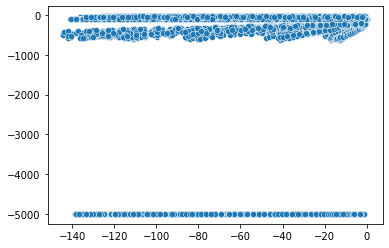

In [ ]:
import seaborn as sns

preds = np.zeros_like(train_list_y[0])
for i, row in enumerate(train_list_X[0]):
    preds[i] = np.clip(f(*row)[0], -5000, 5000)

sns.scatterplot(train_list_y[0], preds)

In [ ]:
'zeides_2a_8_red_2000_cal_10_vel_10_fric_025',
'zeides_2a_8_red_2000_cal_75_vel_10_fric_050',
'zeides_2a_8_red_2500_cal_30_vel_10_fric_0100',
'zeides_2a_8_red_250_cal_0_vel_10_fric_025',
'zeides_2a_8_red_2000_cal_30_vel_10_fric_050'